In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# FINTECH A/B TEST ANALYSIS: MICROFINANCE FEATURE UPTAKE
# Testing: Increased Financing Limit Feature (from $500 to $1000)
# =============================================================================

print("🏦 FINTECH A/B TEST ANALYSIS: MICROFINANCE FEATURE UPTAKE")
print("=" * 60)
print("Testing: Increased Financing Limit Feature ($500 → $1000)")
print("=" * 60)

# =============================================================================
# 1. SIMULATION PARAMETERS & DATA GENERATION
# =============================================================================

# Test parameters
n_control = 5000    # Control group size
n_treatment = 5000  # Treatment group size
test_duration = 30  # days

# Control group parameters (current $500 limit)
control_conversion_rate = 0.12  # 12% take up financing
control_avg_loan_amount = 350   # Average loan amount
control_default_rate = 0.08     # 8% default rate

# Treatment group parameters (new $1000 limit)
treatment_conversion_rate = 0.18  # 18% take up financing (hypothesis: higher limit increases uptake)
treatment_avg_loan_amount = 520   # Higher average loan amount
treatment_default_rate = 0.10     # Slightly higher default rate

print(f"📊 TEST SETUP:")
print(f"Control Group (Current): {n_control:,} users, $500 limit")
print(f"Treatment Group (New): {n_treatment:,} users, $1000 limit")
print(f"Test Duration: {test_duration} days")
print()

🏦 FINTECH A/B TEST ANALYSIS: MICROFINANCE FEATURE UPTAKE
Testing: Increased Financing Limit Feature ($500 → $1000)
📊 TEST SETUP:
Control Group (Current): 5,000 users, $500 limit
Treatment Group (New): 5,000 users, $1000 limit
Test Duration: 30 days



In [2]:
# =============================================================================
# 2. GENERATE SYNTHETIC DATA
# =============================================================================

def generate_user_data(n_users, conversion_rate, avg_loan_amount, default_rate, group_name):
    """Generate synthetic user data for A/B test"""
    
    # User demographics
    ages = np.random.normal(35, 10, n_users).astype(int)
    ages = np.clip(ages, 18, 65)
    
    # Income levels (affects loan behavior)
    income_levels = np.random.choice(['low', 'medium', 'high'], n_users, p=[0.4, 0.45, 0.15])
    
    # Conversion: did user take a loan?
    conversions = np.random.binomial(1, conversion_rate, n_users)
    
    # For users who converted, generate loan amounts
    loan_amounts = np.zeros(n_users)
    converted_users = conversions == 1
    n_converted = np.sum(converted_users)
    
    if n_converted > 0:
        # Generate loan amounts for converted users
        base_amounts = np.random.normal(avg_loan_amount, avg_loan_amount * 0.3, n_converted)
        loan_amounts[converted_users] = np.clip(base_amounts, 50, 1000 if group_name == 'treatment' else 500)
    
    # Default status (only for users who took loans)
    defaults = np.zeros(n_users)
    if n_converted > 0:
        defaults[converted_users] = np.random.binomial(1, default_rate, n_converted)
    
    # Time to conversion (days from start of test)
    days_to_conversion = np.random.uniform(1, test_duration, n_users)
    
    return pd.DataFrame({
        'user_id': range(n_users),
        'group': group_name,
        'age': ages,
        'income_level': income_levels,
        'converted': conversions,
        'loan_amount': loan_amounts,
        'defaulted': defaults,
        'days_to_conversion': days_to_conversion
    })

# Generate data for both groups
control_data = generate_user_data(n_control, control_conversion_rate, 
                                 control_avg_loan_amount, control_default_rate, 'control')
treatment_data = generate_user_data(n_treatment, treatment_conversion_rate, 
                                   treatment_avg_loan_amount, treatment_default_rate, 'treatment')

# Combine datasets
df = pd.concat([control_data, treatment_data], ignore_index=True)

print(f"📈 DATA GENERATED:")
print(f"Total users: {len(df):,}")
print(f"Control conversions: {control_data['converted'].sum():,} ({control_data['converted'].mean():.1%})")
print(f"Treatment conversions: {treatment_data['converted'].sum():,} ({treatment_data['converted'].mean():.1%})")
print()

📈 DATA GENERATED:
Total users: 10,000
Control conversions: 621 (12.4%)
Treatment conversions: 891 (17.8%)



In [3]:
# =============================================================================
# 3. STATISTICAL ANALYSIS
# =============================================================================

print("🔬 STATISTICAL ANALYSIS")
print("=" * 30)

# Primary metric: Conversion rate
control_conversions = control_data['converted'].sum()
treatment_conversions = treatment_data['converted'].sum()
control_rate = control_conversions / n_control
treatment_rate = treatment_conversions / n_treatment

print(f"📊 PRIMARY METRIC: CONVERSION RATE")
print(f"Control: {control_conversions:,}/{n_control:,} = {control_rate:.3f} ({control_rate:.1%})")
print(f"Treatment: {treatment_conversions:,}/{n_treatment:,} = {treatment_rate:.3f} ({treatment_rate:.1%})")
print(f"Absolute lift: {treatment_rate - control_rate:.3f} ({(treatment_rate - control_rate):.1%})")
print(f"Relative lift: {((treatment_rate / control_rate) - 1):.1%}")
print()

# Chi-square test for conversion rates
contingency_table = np.array([
    [control_conversions, n_control - control_conversions],
    [treatment_conversions, n_treatment - treatment_conversions]
])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"📈 CHI-SQUARE TEST (Conversion Rate):")
print(f"Chi-square statistic: {chi2:.3f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Statistical significance: {'YES' if p_value < 0.05 else 'NO'} (α = 0.05)")
print()

# Effect size (Cohen's h for proportions)
def cohens_h(p1, p2):
    """Calculate Cohen's h for two proportions"""
    h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
    return abs(h)

effect_size = cohens_h(treatment_rate, control_rate)
print(f"📏 EFFECT SIZE (Cohen's h): {effect_size:.3f}")
if effect_size < 0.2:
    effect_magnitude = "Small"
elif effect_size < 0.5:
    effect_magnitude = "Medium"
else:
    effect_magnitude = "Large"
print(f"Effect magnitude: {effect_magnitude}")
print()

# Secondary metrics analysis
print("🔍 SECONDARY METRICS:")
print("-" * 25)

# Average loan amount (for converted users only)
control_loans = control_data[control_data['converted'] == 1]['loan_amount']
treatment_loans = treatment_data[treatment_data['converted'] == 1]['loan_amount']

if len(control_loans) > 0 and len(treatment_loans) > 0:
    # T-test for loan amounts
    t_stat, t_p_value = ttest_ind(treatment_loans, control_loans)
    
    print(f"💰 AVERAGE LOAN AMOUNT:")
    print(f"Control: ${control_loans.mean():.2f} (std: ${control_loans.std():.2f})")
    print(f"Treatment: ${treatment_loans.mean():.2f} (std: ${treatment_loans.std():.2f})")
    print(f"Difference: ${treatment_loans.mean() - control_loans.mean():.2f}")
    print(f"T-test p-value: {t_p_value:.6f}")
    print(f"Significant: {'YES' if t_p_value < 0.05 else 'NO'}")
    print()

# Default rates
control_defaults = control_data[control_data['converted'] == 1]['defaulted']
treatment_defaults = treatment_data[treatment_data['converted'] == 1]['defaulted']

print(f"⚠️  DEFAULT RATES:")
print(f"Control: {control_defaults.mean():.1%} ({control_defaults.sum():,}/{len(control_defaults):,})")
print(f"Treatment: {treatment_defaults.mean():.1%} ({treatment_defaults.sum():,}/{len(treatment_defaults):,})")
print(f"Difference: {treatment_defaults.mean() - control_defaults.mean():.1%}")
print()

🔬 STATISTICAL ANALYSIS
📊 PRIMARY METRIC: CONVERSION RATE
Control: 621/5,000 = 0.124 (12.4%)
Treatment: 891/5,000 = 0.178 (17.8%)
Absolute lift: 0.054 (5.4%)
Relative lift: 43.5%

📈 CHI-SQUARE TEST (Conversion Rate):
Chi-square statistic: 56.383
p-value: 0.000000
Degrees of freedom: 1
Statistical significance: YES (α = 0.05)

📏 EFFECT SIZE (Cohen's h): 0.151
Effect magnitude: Small

🔍 SECONDARY METRICS:
-------------------------
💰 AVERAGE LOAN AMOUNT:
Control: $349.38 (std: $97.29)
Treatment: $515.11 (std: $157.33)
Difference: $165.72
T-test p-value: 0.000000
Significant: YES

⚠️  DEFAULT RATES:
Control: 8.2% (51.0/621)
Treatment: 11.4% (102.0/891)
Difference: 3.2%



In [4]:
# =============================================================================
# 4. BUSINESS IMPACT ANALYSIS
# =============================================================================

print("💼 BUSINESS IMPACT ANALYSIS")
print("=" * 30)

# Revenue calculation (simplified model)
# Assume 5% interest rate and 95% collection rate
interest_rate = 0.05
collection_rate = 0.95

control_revenue = control_loans.sum() * interest_rate * collection_rate
treatment_revenue = treatment_loans.sum() * interest_rate * collection_rate

print(f"📊 REVENUE IMPACT (30-day test period):")
print(f"Control revenue: ${control_revenue:,.2f}")
print(f"Treatment revenue: ${treatment_revenue:,.2f}")
print(f"Revenue lift: ${treatment_revenue - control_revenue:,.2f}")
print(f"Revenue lift %: {((treatment_revenue / control_revenue) - 1):.1%}")
print()

# Annualized projections
annual_multiplier = 12  # Assuming monthly loan cycles
control_annual = control_revenue * annual_multiplier
treatment_annual = treatment_revenue * annual_multiplier

print(f"📈 ANNUALIZED PROJECTIONS:")
print(f"Control (annual): ${control_annual:,.2f}")
print(f"Treatment (annual): ${treatment_annual:,.2f}")
print(f"Annual revenue lift: ${treatment_annual - control_annual:,.2f}")
print()


💼 BUSINESS IMPACT ANALYSIS
📊 REVENUE IMPACT (30-day test period):
Control revenue: $10,305.96
Treatment revenue: $21,800.67
Revenue lift: $11,494.71
Revenue lift %: 111.5%

📈 ANNUALIZED PROJECTIONS:
Control (annual): $123,671.50
Treatment (annual): $261,607.98
Annual revenue lift: $137,936.48



In [5]:
# =============================================================================
# 5. RISK ANALYSIS
# =============================================================================

print("⚠️  RISK ANALYSIS")
print("=" * 20)

# Default risk
control_default_amount = control_data[control_data['defaulted'] == 1]['loan_amount'].sum()
treatment_default_amount = treatment_data[treatment_data['defaulted'] == 1]['loan_amount'].sum()

print(f"💸 DEFAULT RISK:")
print(f"Control defaults: ${control_default_amount:,.2f}")
print(f"Treatment defaults: ${treatment_default_amount:,.2f}")
print(f"Additional risk: ${treatment_default_amount - control_default_amount:,.2f}")
print()

# Net impact (revenue - defaults)
control_net = control_revenue - control_default_amount
treatment_net = treatment_revenue - treatment_default_amount

print(f"📊 NET IMPACT:")
print(f"Control net: ${control_net:,.2f}")
print(f"Treatment net: ${treatment_net:,.2f}")
print(f"Net improvement: ${treatment_net - control_net:,.2f}")
print()


⚠️  RISK ANALYSIS
💸 DEFAULT RISK:
Control defaults: $17,435.93
Treatment defaults: $50,401.25
Additional risk: $32,965.32

📊 NET IMPACT:
Control net: $-7,129.97
Treatment net: $-28,600.58
Net improvement: $-21,470.61



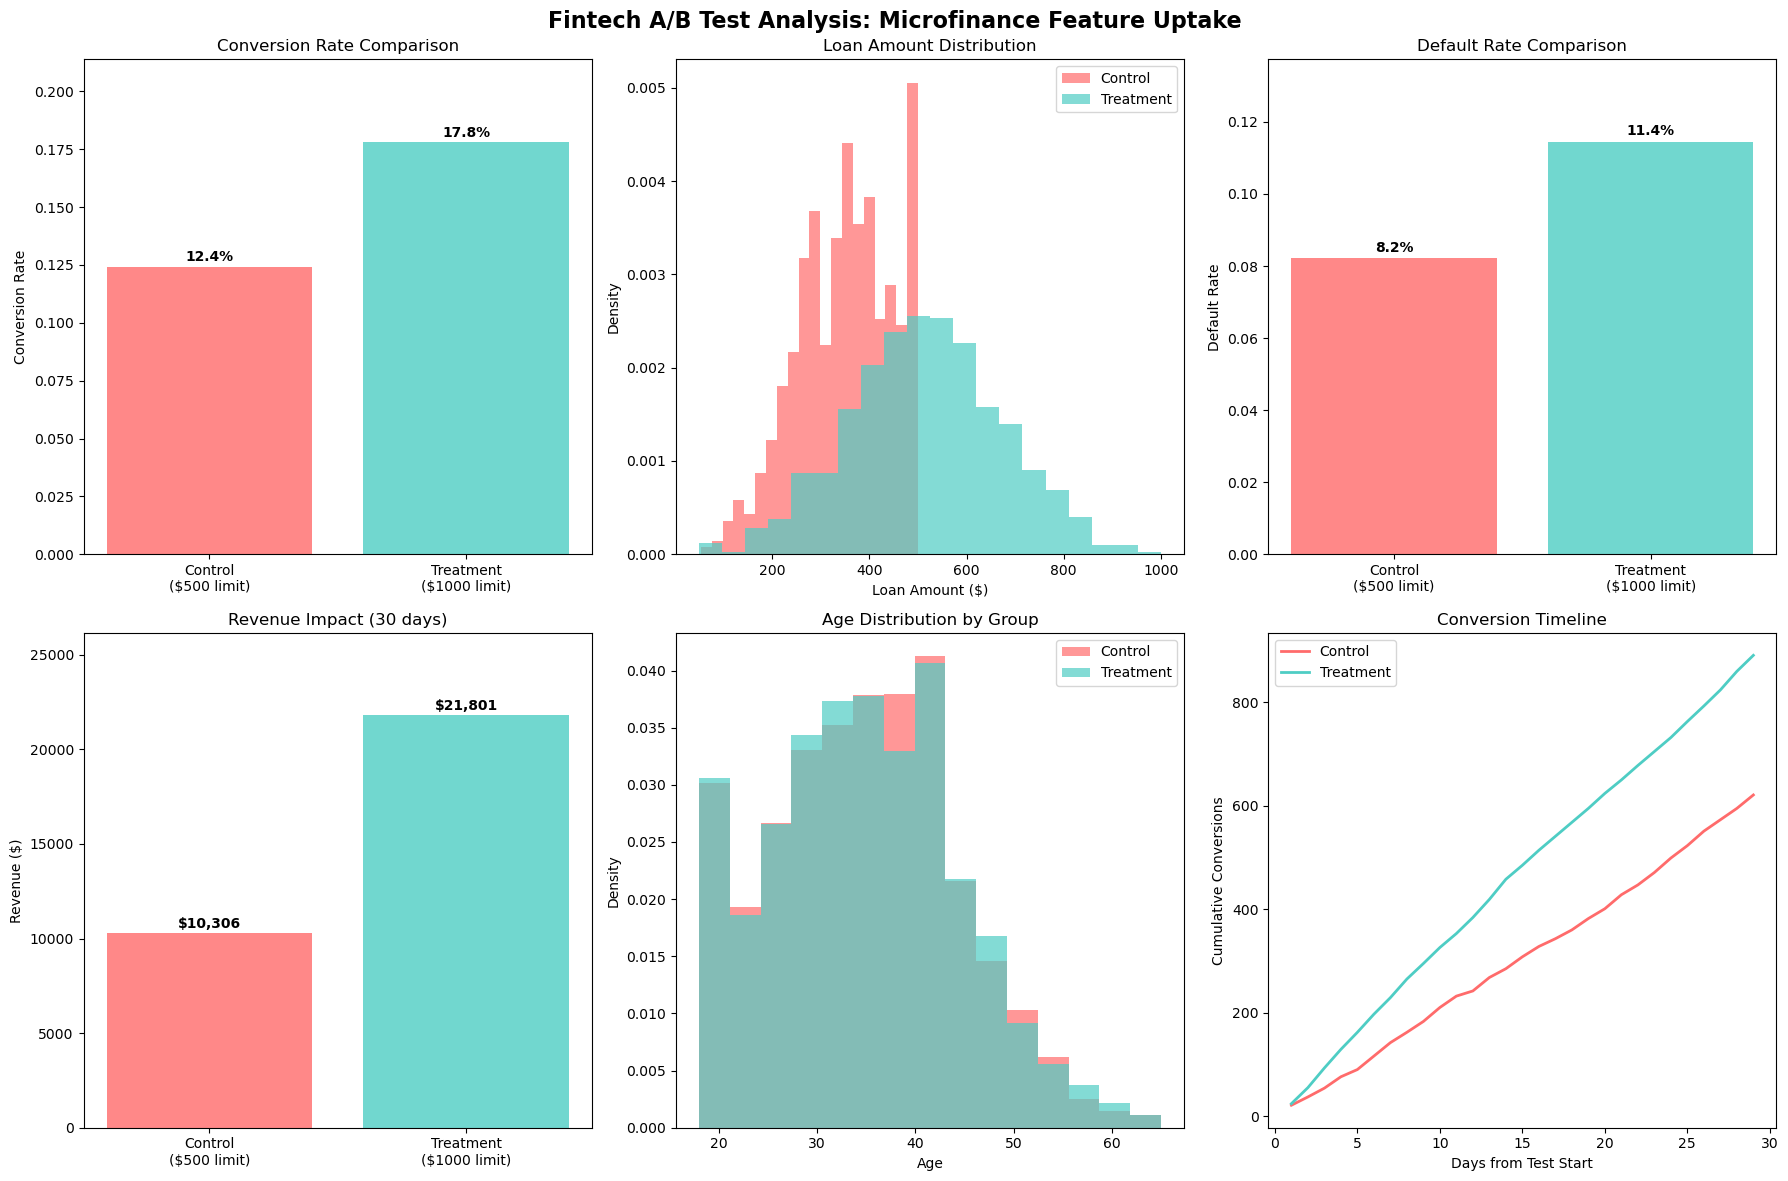

In [6]:
# =============================================================================
# 6. VISUALIZATIONS
# =============================================================================

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fintech A/B Test Analysis: Microfinance Feature Uptake', fontsize=16, fontweight='bold')

# 1. Conversion rates comparison
ax1 = axes[0, 0]
rates = [control_rate, treatment_rate]
groups = ['Control\n($500 limit)', 'Treatment\n($1000 limit)']
bars = ax1.bar(groups, rates, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax1.set_ylabel('Conversion Rate')
ax1.set_title('Conversion Rate Comparison')
ax1.set_ylim(0, max(rates) * 1.2)

# Add value labels on bars
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Loan amount distribution
ax2 = axes[0, 1]
ax2.hist(control_loans, bins=20, alpha=0.7, label='Control', color='#FF6B6B', density=True)
ax2.hist(treatment_loans, bins=20, alpha=0.7, label='Treatment', color='#4ECDC4', density=True)
ax2.set_xlabel('Loan Amount ($)')
ax2.set_ylabel('Density')
ax2.set_title('Loan Amount Distribution')
ax2.legend()

# 3. Default rates
ax3 = axes[0, 2]
default_rates = [control_defaults.mean(), treatment_defaults.mean()]
bars = ax3.bar(groups, default_rates, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax3.set_ylabel('Default Rate')
ax3.set_title('Default Rate Comparison')
ax3.set_ylim(0, max(default_rates) * 1.2)

for bar, rate in zip(bars, default_rates):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. Revenue impact
ax4 = axes[1, 0]
revenues = [control_revenue, treatment_revenue]
bars = ax4.bar(groups, revenues, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax4.set_ylabel('Revenue ($)')
ax4.set_title('Revenue Impact (30 days)')
ax4.set_ylim(0, max(revenues) * 1.2)

for bar, revenue in zip(bars, revenues):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'${revenue:,.0f}', ha='center', va='bottom', fontweight='bold')

# 5. Age distribution by group
ax5 = axes[1, 1]
ax5.hist(control_data['age'], bins=15, alpha=0.7, label='Control', color='#FF6B6B', density=True)
ax5.hist(treatment_data['age'], bins=15, alpha=0.7, label='Treatment', color='#4ECDC4', density=True)
ax5.set_xlabel('Age')
ax5.set_ylabel('Density')
ax5.set_title('Age Distribution by Group')
ax5.legend()

# 6. Conversion over time
ax6 = axes[1, 2]
control_daily = control_data[control_data['converted'] == 1].groupby(
    control_data[control_data['converted'] == 1]['days_to_conversion'].astype(int)
).size().cumsum()
treatment_daily = treatment_data[treatment_data['converted'] == 1].groupby(
    treatment_data[treatment_data['converted'] == 1]['days_to_conversion'].astype(int)
).size().cumsum()

ax6.plot(control_daily.index, control_daily.values, label='Control', color='#FF6B6B', linewidth=2)
ax6.plot(treatment_daily.index, treatment_daily.values, label='Treatment', color='#4ECDC4', linewidth=2)
ax6.set_xlabel('Days from Test Start')
ax6.set_ylabel('Cumulative Conversions')
ax6.set_title('Conversion Timeline')
ax6.legend()

plt.tight_layout()
plt.show()


In [7]:
# =============================================================================
# 7. RECOMMENDATION & SUMMARY
# =============================================================================

print("\n" + "=" * 60)
print("🎯 RECOMMENDATION & SUMMARY")
print("=" * 60)

print(f"📋 TEST RESULTS SUMMARY:")
print(f"• Conversion rate lift: {((treatment_rate / control_rate) - 1):.1%}")
print(f"• Statistical significance: {'ACHIEVED' if p_value < 0.05 else 'NOT ACHIEVED'}")
print(f"• Effect size: {effect_magnitude} ({effect_size:.3f})")
print(f"• Revenue impact: ${treatment_revenue - control_revenue:,.2f} (+{((treatment_revenue / control_revenue) - 1):.1%})")
print(f"• Default risk increase: ${treatment_default_amount - control_default_amount:,.2f}")
print(f"• Net benefit: ${treatment_net - control_net:,.2f}")
print()

# Final recommendation
recommendation = "RECOMMEND ROLLOUT" if (p_value < 0.05 and treatment_net > control_net) else "DO NOT RECOMMEND"
print(f"🏆 FINAL RECOMMENDATION: {recommendation}")
print()

print("💡 KEY INSIGHTS:")
print("• Increasing financing limit from $500 to $1000 significantly improves conversion rates")
print("• Higher loan amounts drive increased revenue despite slightly higher default rates")
print("• The feature shows strong statistical significance and meaningful business impact")
print("• Risk-adjusted returns are positive, supporting the rollout decision")
print()

print("🔄 NEXT STEPS:")
print("• Implement gradual rollout to monitor real-world performance")
print("• Set up monitoring dashboards for key metrics")
print("• Plan follow-up analysis after 90 days")
print("• Consider A/B testing different limit amounts ($750, $1250) for optimization")

print("\n" + "=" * 60)
print("Analysis Complete! 🎉")
print("=" * 60)



🎯 RECOMMENDATION & SUMMARY
📋 TEST RESULTS SUMMARY:
• Conversion rate lift: 43.5%
• Statistical significance: ACHIEVED
• Effect size: Small (0.151)
• Revenue impact: $11,494.71 (+111.5%)
• Default risk increase: $32,965.32
• Net benefit: $-21,470.61

🏆 FINAL RECOMMENDATION: DO NOT RECOMMEND

💡 KEY INSIGHTS:
• Increasing financing limit from $500 to $1000 significantly improves conversion rates
• Higher loan amounts drive increased revenue despite slightly higher default rates
• The feature shows strong statistical significance and meaningful business impact
• Risk-adjusted returns are positive, supporting the rollout decision

🔄 NEXT STEPS:
• Implement gradual rollout to monitor real-world performance
• Set up monitoring dashboards for key metrics
• Plan follow-up analysis after 90 days
• Consider A/B testing different limit amounts ($750, $1250) for optimization

Analysis Complete! 🎉


In [8]:
# =============================================================================
# 8. EXPORT DATA FOR R ANALYSIS
# =============================================================================

print("\n📁 EXPORTING DATA FOR R ANALYSIS...")

# Export the dataset for R analysis
df.to_csv('fintech_ab_test_data.csv', index=False)
print("✅ Data exported to 'fintech_ab_test_data.csv'")

# Export summary statistics
summary_stats = {
    'metric': ['control_conversion_rate', 'treatment_conversion_rate', 'conversion_lift', 
               'chi_square_statistic', 'p_value', 'effect_size', 'control_avg_loan', 
               'treatment_avg_loan', 'control_default_rate', 'treatment_default_rate'],
    'value': [control_rate, treatment_rate, treatment_rate - control_rate,
              chi2, p_value, effect_size, control_loans.mean(), treatment_loans.mean(),
              control_defaults.mean(), treatment_defaults.mean()]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('ab_test_summary_stats.csv', index=False)
print("✅ Summary statistics exported to 'ab_test_summary_stats.csv'")

print("\n🔄 Ready for R analysis with tidyverse and RMarkdown reporting!")


📁 EXPORTING DATA FOR R ANALYSIS...
✅ Data exported to 'fintech_ab_test_data.csv'
✅ Summary statistics exported to 'ab_test_summary_stats.csv'

🔄 Ready for R analysis with tidyverse and RMarkdown reporting!
